### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_benign/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_benign/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_benign/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_benign/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 261 elements
My custom valing-dataset has 88 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

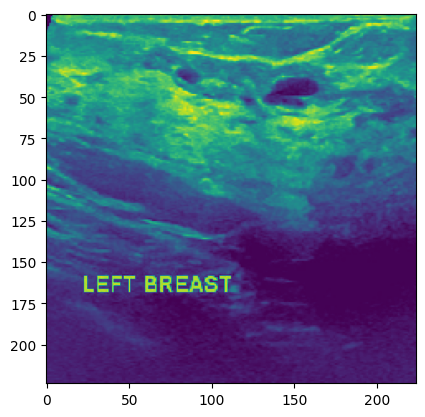

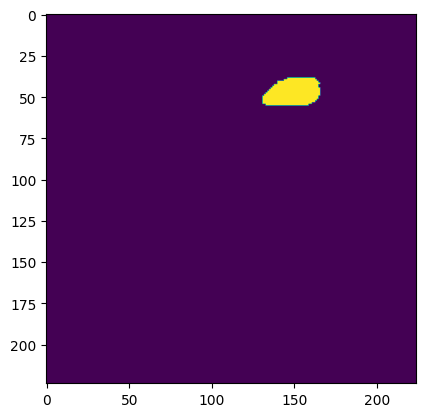

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_medical_seg_models.unet import UNet

model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'Unet'
data_name = 'benign'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 33 of 33, Train Loss: 1.274623, IoU: 0.273810, Dice: 0.372108
 Epoch: 1 of 100, Iter.: 33 of 33, Valid Loss: 1.281552, IoU: 0.207563, Dice: 0.299842

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


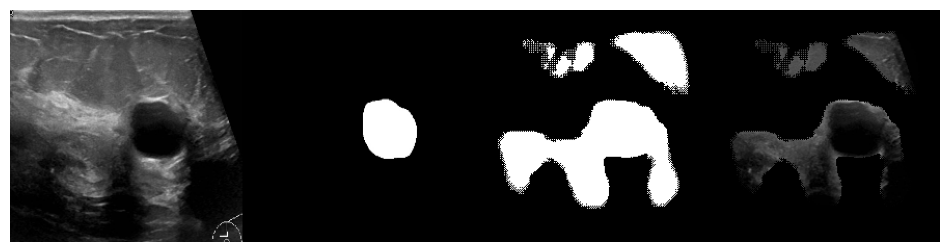

 Epoch: 2 of 100, Iter.: 33 of 33, Train Loss: 1.110023, IoU: 0.380595, Dice: 0.480301
 Epoch: 2 of 100, Iter.: 33 of 33, Valid Loss: 1.160685, IoU: 0.282601, Dice: 0.388224


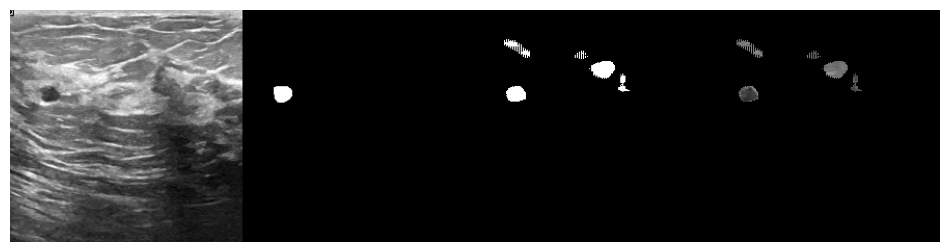

 Epoch: 3 of 100, Iter.: 33 of 33, Train Loss: 1.041387, IoU: 0.439303, Dice: 0.548080
 Epoch: 3 of 100, Iter.: 33 of 33, Valid Loss: 1.005635, IoU: 0.428809, Dice: 0.542056


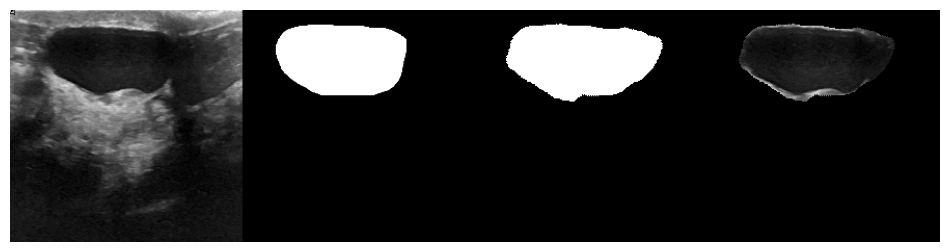

 Epoch: 4 of 100, Iter.: 33 of 33, Train Loss: 0.996557, IoU: 0.455826, Dice: 0.568338
 Epoch: 4 of 100, Iter.: 33 of 33, Valid Loss: 1.026095, IoU: 0.355661, Dice: 0.462012


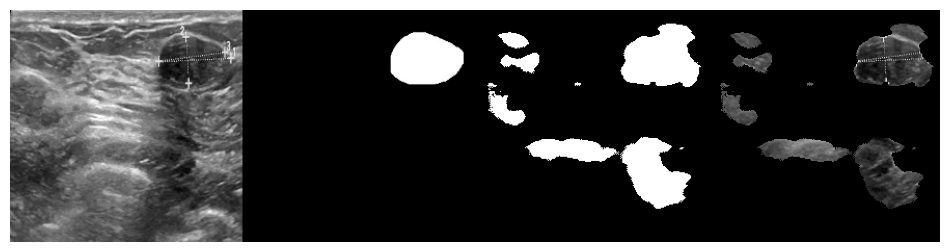

 Epoch: 5 of 100, Iter.: 33 of 33, Train Loss: 0.951861, IoU: 0.484803, Dice: 0.598595
 Epoch: 5 of 100, Iter.: 33 of 33, Valid Loss: 1.033559, IoU: 0.328206, Dice: 0.440337


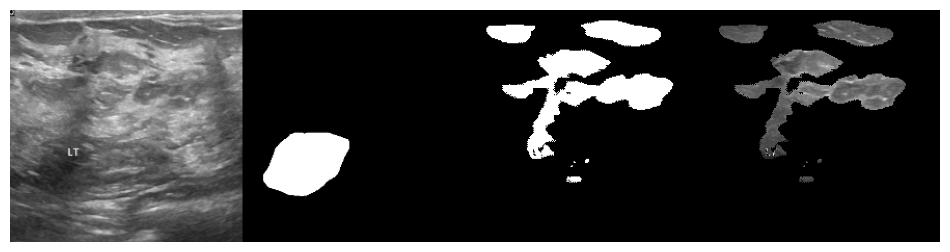

 Epoch: 6 of 100, Iter.: 33 of 33, Train Loss: 0.910774, IoU: 0.489665, Dice: 0.603293
 Epoch: 6 of 100, Iter.: 33 of 33, Valid Loss: 0.938791, IoU: 0.516372, Dice: 0.622463


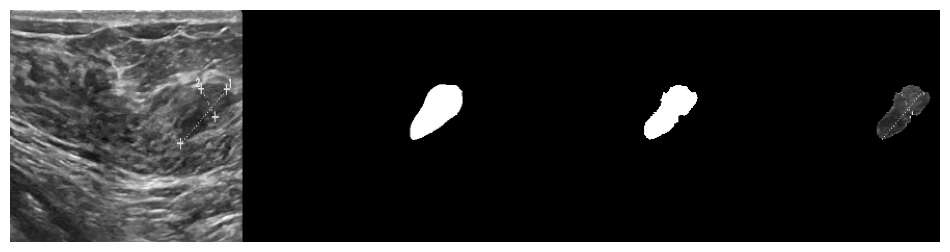

 Epoch: 7 of 100, Iter.: 33 of 33, Train Loss: 0.880902, IoU: 0.529634, Dice: 0.636056
 Epoch: 7 of 100, Iter.: 33 of 33, Valid Loss: 0.913316, IoU: 0.444596, Dice: 0.548548


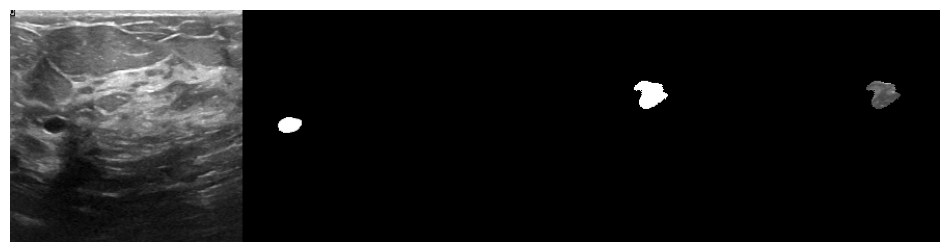

 Epoch: 8 of 100, Iter.: 33 of 33, Train Loss: 0.856528, IoU: 0.514865, Dice: 0.622676
 Epoch: 8 of 100, Iter.: 33 of 33, Valid Loss: 0.872153, IoU: 0.459272, Dice: 0.572181


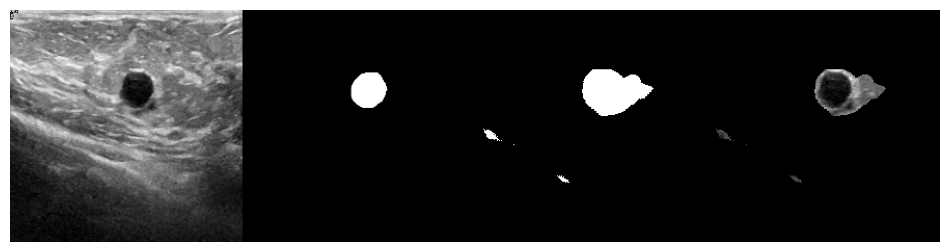

 Epoch: 9 of 100, Iter.: 33 of 33, Train Loss: 0.825838, IoU: 0.536793, Dice: 0.648092
 Epoch: 9 of 100, Iter.: 33 of 33, Valid Loss: 0.916901, IoU: 0.316826, Dice: 0.370250


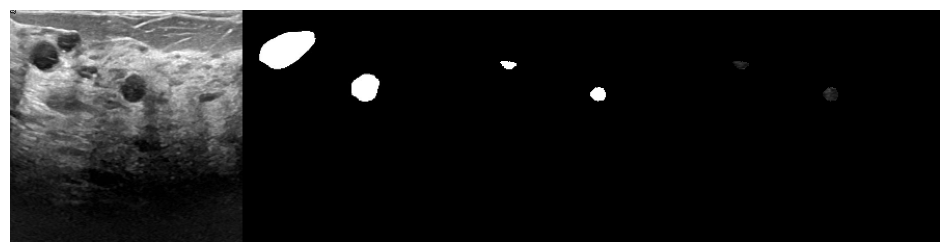

 Epoch: 10 of 100, Iter.: 33 of 33, Train Loss: 0.807981, IoU: 0.542023, Dice: 0.647534
 Epoch: 10 of 100, Iter.: 33 of 33, Valid Loss: 0.810964, IoU: 0.531932, Dice: 0.635696


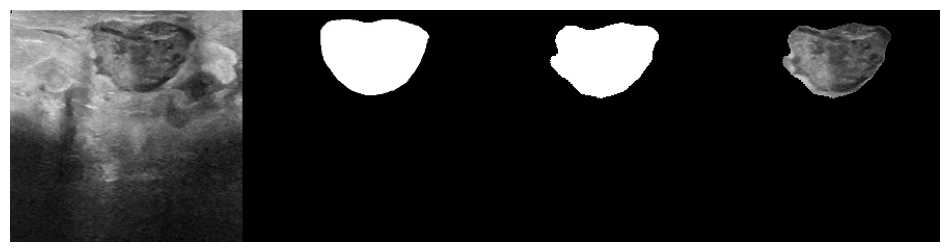

 Epoch: 11 of 100, Iter.: 33 of 33, Train Loss: 0.751335, IoU: 0.572913, Dice: 0.679488
 Epoch: 11 of 100, Iter.: 33 of 33, Valid Loss: 0.958460, IoU: 0.339048, Dice: 0.441751


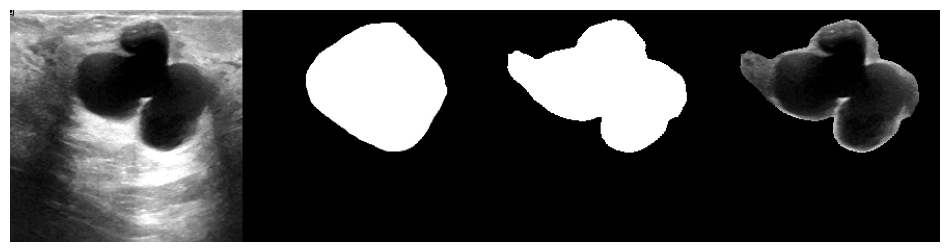

 Epoch: 12 of 100, Iter.: 33 of 33, Train Loss: 0.770733, IoU: 0.549405, Dice: 0.659188
 Epoch: 12 of 100, Iter.: 33 of 33, Valid Loss: 0.766105, IoU: 0.474738, Dice: 0.554612


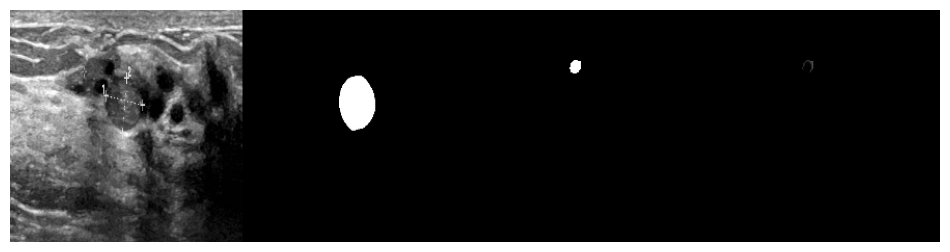

 Epoch: 13 of 100, Iter.: 33 of 33, Train Loss: 0.717362, IoU: 0.566152, Dice: 0.675927
 Epoch: 13 of 100, Iter.: 33 of 33, Valid Loss: 0.768417, IoU: 0.492661, Dice: 0.599894


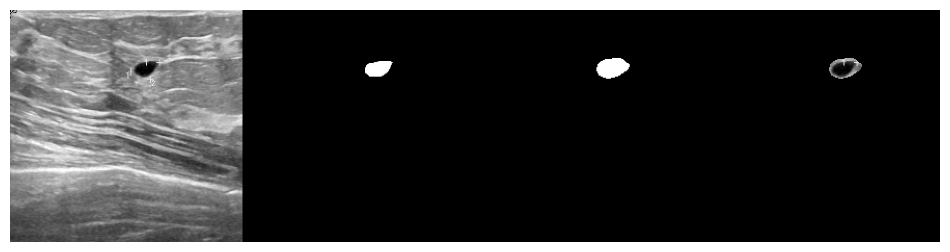

 Epoch: 14 of 100, Iter.: 33 of 33, Train Loss: 0.684659, IoU: 0.618728, Dice: 0.720732
 Epoch: 14 of 100, Iter.: 33 of 33, Valid Loss: 0.709441, IoU: 0.524859, Dice: 0.620827


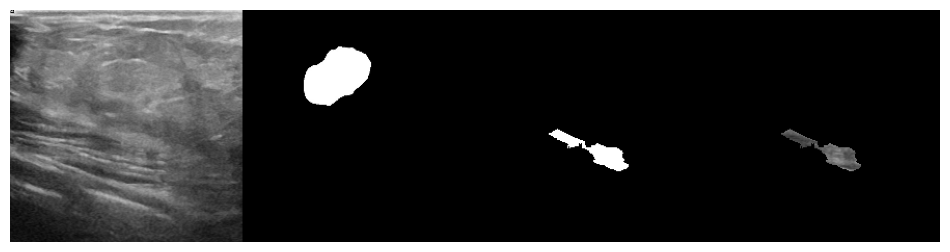

 Epoch: 15 of 100, Iter.: 33 of 33, Train Loss: 0.656644, IoU: 0.627184, Dice: 0.727592
 Epoch: 15 of 100, Iter.: 33 of 33, Valid Loss: 0.815577, IoU: 0.383446, Dice: 0.489954


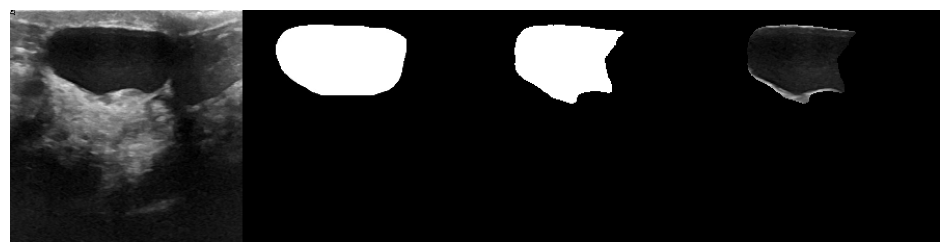

 Epoch: 16 of 100, Iter.: 33 of 33, Train Loss: 0.656065, IoU: 0.606081, Dice: 0.710951
 Epoch: 16 of 100, Iter.: 33 of 33, Valid Loss: 0.720707, IoU: 0.463897, Dice: 0.568767


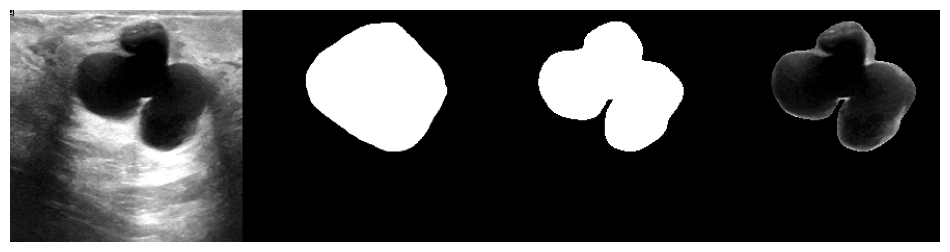

 Epoch: 17 of 100, Iter.: 33 of 33, Train Loss: 0.595918, IoU: 0.655845, Dice: 0.755420
 Epoch: 17 of 100, Iter.: 33 of 33, Valid Loss: 0.629273, IoU: 0.589802, Dice: 0.676335


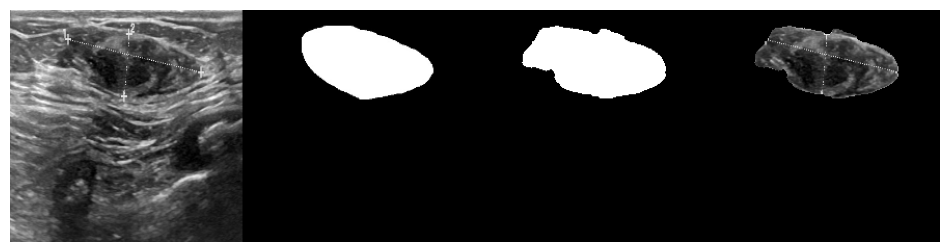

 Epoch: 18 of 100, Iter.: 33 of 33, Train Loss: 0.595106, IoU: 0.651334, Dice: 0.743552
 Epoch: 18 of 100, Iter.: 33 of 33, Valid Loss: 0.642170, IoU: 0.580722, Dice: 0.675855


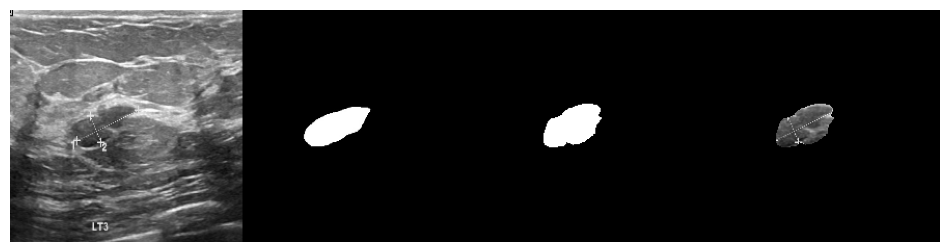

 Epoch: 19 of 100, Iter.: 33 of 33, Train Loss: 0.572543, IoU: 0.647446, Dice: 0.749320
 Epoch: 19 of 100, Iter.: 33 of 33, Valid Loss: 0.733764, IoU: 0.436168, Dice: 0.534588


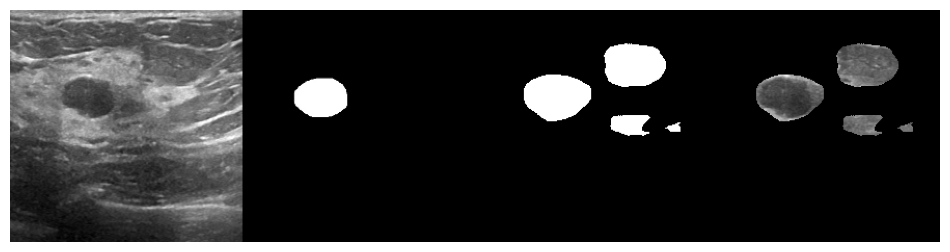

 Epoch: 20 of 100, Iter.: 33 of 33, Train Loss: 0.540471, IoU: 0.656674, Dice: 0.748092
 Epoch: 20 of 100, Iter.: 33 of 33, Valid Loss: 0.625165, IoU: 0.549544, Dice: 0.634648


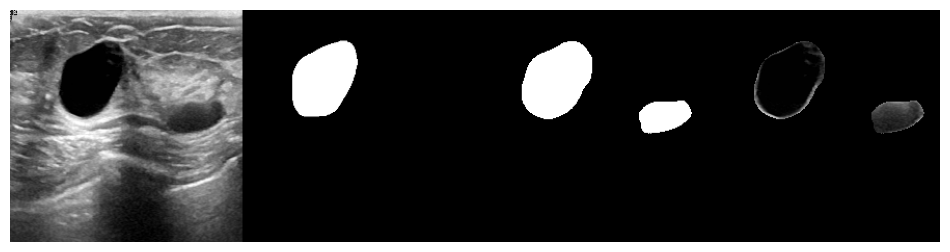

 Epoch: 21 of 100, Iter.: 33 of 33, Train Loss: 0.507782, IoU: 0.697740, Dice: 0.786200
 Epoch: 21 of 100, Iter.: 33 of 33, Valid Loss: 0.558708, IoU: 0.595477, Dice: 0.683509


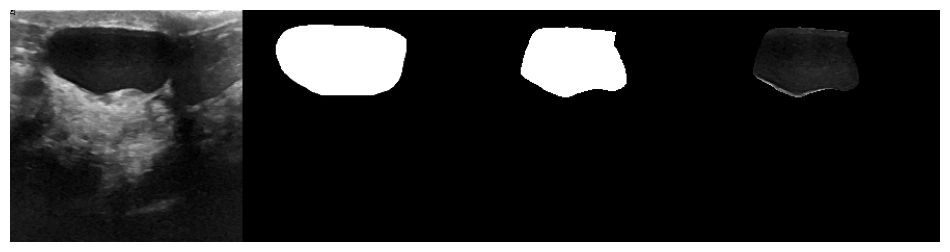

 Epoch: 22 of 100, Iter.: 33 of 33, Train Loss: 0.506987, IoU: 0.695342, Dice: 0.787777
 Epoch: 22 of 100, Iter.: 33 of 33, Valid Loss: 0.576278, IoU: 0.572248, Dice: 0.675297


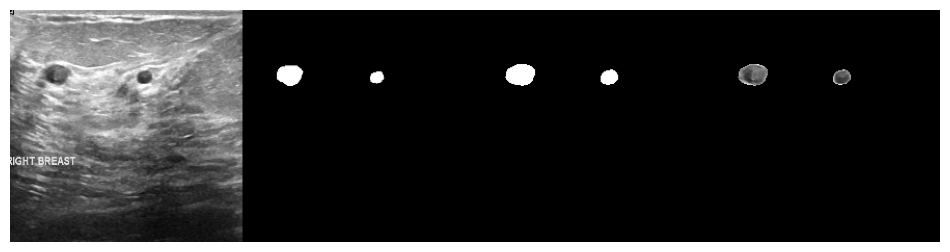

 Epoch: 23 of 100, Iter.: 33 of 33, Train Loss: 0.456394, IoU: 0.716911, Dice: 0.805117
 Epoch: 23 of 100, Iter.: 33 of 33, Valid Loss: 0.556629, IoU: 0.557951, Dice: 0.654569


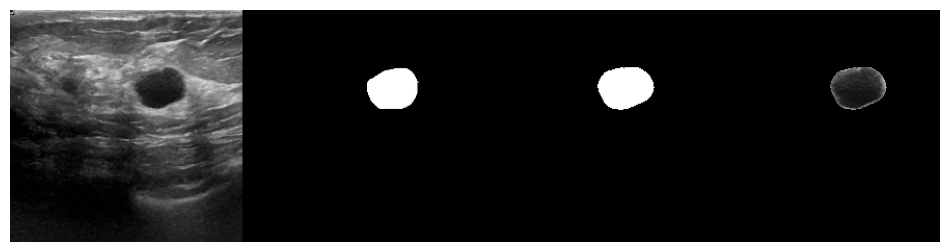

 Epoch: 24 of 100, Iter.: 33 of 33, Train Loss: 0.451613, IoU: 0.711479, Dice: 0.804144
 Epoch: 24 of 100, Iter.: 33 of 33, Valid Loss: 0.551430, IoU: 0.598167, Dice: 0.695474


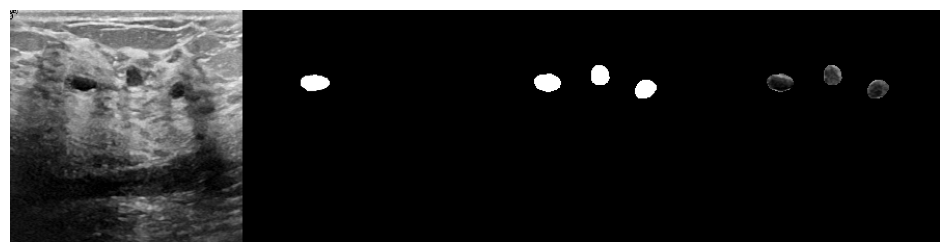

 Epoch: 25 of 100, Iter.: 33 of 33, Train Loss: 0.430425, IoU: 0.714540, Dice: 0.802421
 Epoch: 25 of 100, Iter.: 33 of 33, Valid Loss: 0.637530, IoU: 0.504947, Dice: 0.591217


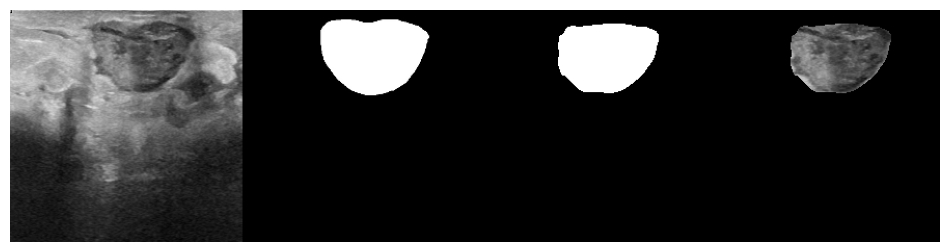

 Epoch: 26 of 100, Iter.: 33 of 33, Train Loss: 0.433385, IoU: 0.715403, Dice: 0.808345
 Epoch: 26 of 100, Iter.: 33 of 33, Valid Loss: 0.490515, IoU: 0.616911, Dice: 0.708857


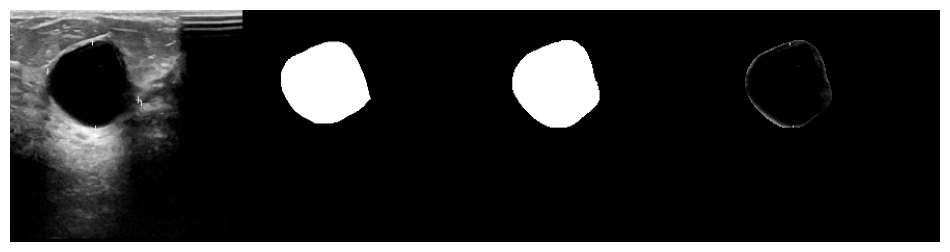

 Epoch: 27 of 100, Iter.: 33 of 33, Train Loss: 0.425194, IoU: 0.718936, Dice: 0.805706
 Epoch: 27 of 100, Iter.: 33 of 33, Valid Loss: 0.511594, IoU: 0.586466, Dice: 0.683150


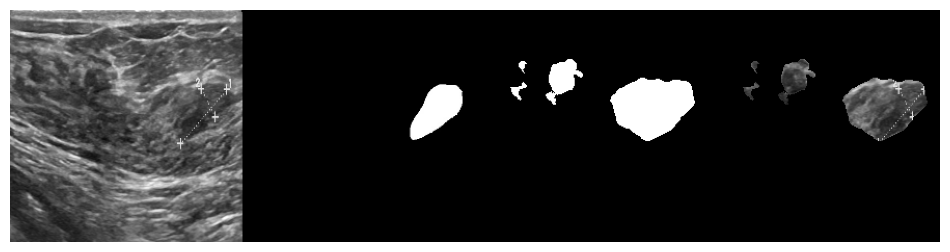

 Epoch: 28 of 100, Iter.: 33 of 33, Train Loss: 0.390854, IoU: 0.724212, Dice: 0.811392
 Epoch: 28 of 100, Iter.: 33 of 33, Valid Loss: 0.544408, IoU: 0.538613, Dice: 0.635727


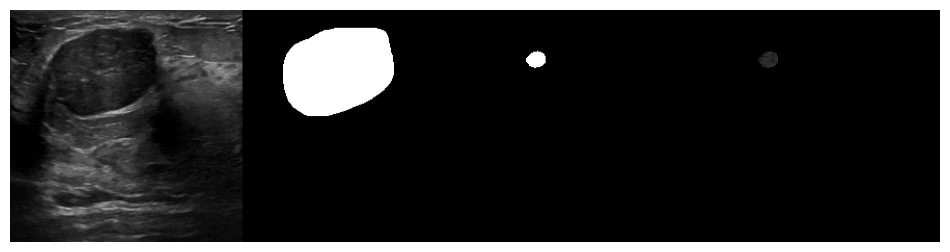

 Epoch: 29 of 100, Iter.: 33 of 33, Train Loss: 0.363501, IoU: 0.762626, Dice: 0.843213
 Epoch: 29 of 100, Iter.: 33 of 33, Valid Loss: 0.507103, IoU: 0.591101, Dice: 0.678191


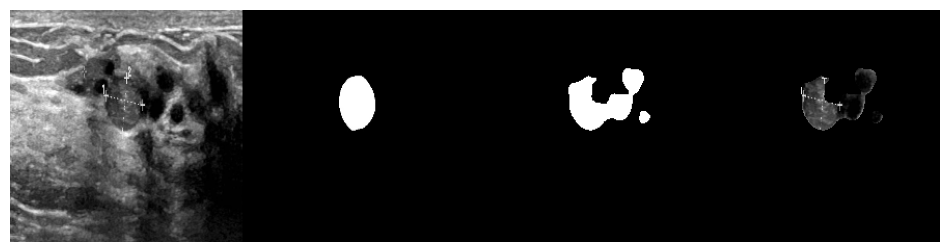

 Epoch: 30 of 100, Iter.: 33 of 33, Train Loss: 0.328391, IoU: 0.780929, Dice: 0.858493
 Epoch: 30 of 100, Iter.: 33 of 33, Valid Loss: 0.457510, IoU: 0.618215, Dice: 0.705433


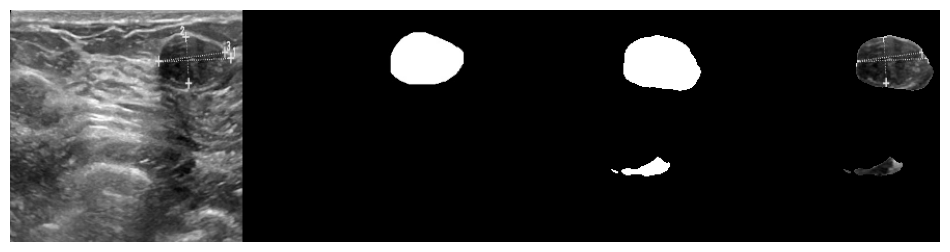

 Epoch: 31 of 100, Iter.: 33 of 33, Train Loss: 0.309207, IoU: 0.787280, Dice: 0.863386
 Epoch: 31 of 100, Iter.: 33 of 33, Valid Loss: 0.486361, IoU: 0.613845, Dice: 0.699336


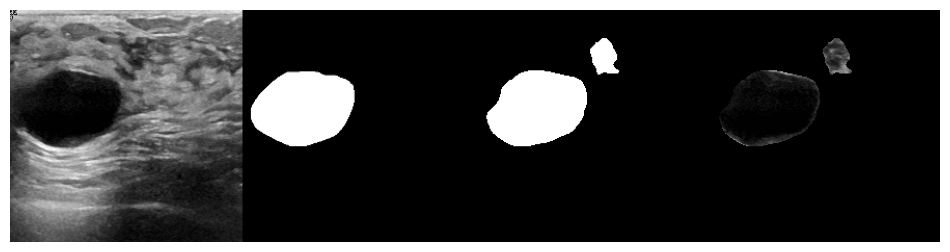

 Epoch: 32 of 100, Iter.: 33 of 33, Train Loss: 0.314299, IoU: 0.772609, Dice: 0.847124
 Epoch: 32 of 100, Iter.: 33 of 33, Valid Loss: 0.535358, IoU: 0.528197, Dice: 0.609208


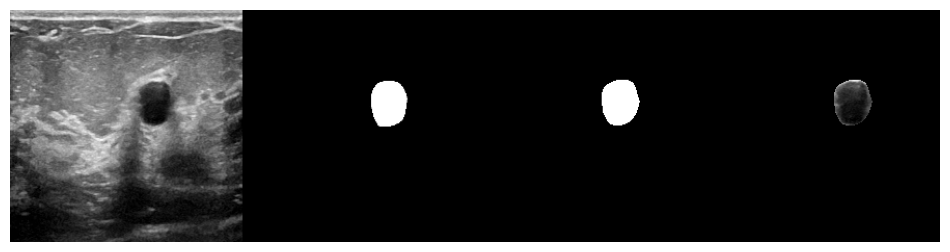

 Epoch: 33 of 100, Iter.: 33 of 33, Train Loss: 0.300917, IoU: 0.788759, Dice: 0.861411
 Epoch: 33 of 100, Iter.: 33 of 33, Valid Loss: 0.480354, IoU: 0.625556, Dice: 0.716755


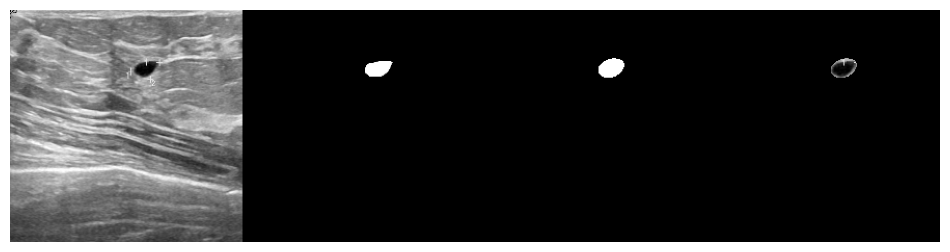

 Epoch: 34 of 100, Iter.: 33 of 33, Train Loss: 0.311200, IoU: 0.762436, Dice: 0.841852
 Epoch: 34 of 100, Iter.: 33 of 33, Valid Loss: 0.469770, IoU: 0.583675, Dice: 0.671773


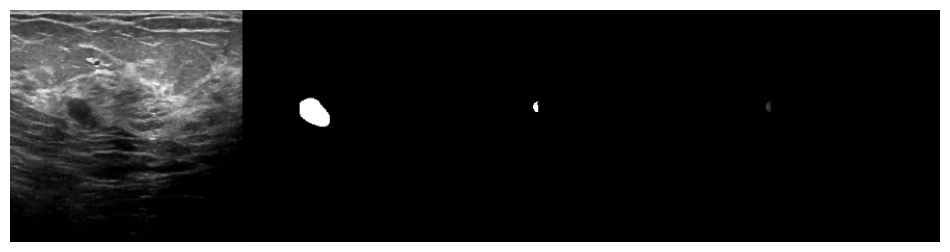

 Epoch: 35 of 100, Iter.: 33 of 33, Train Loss: 0.280198, IoU: 0.777963, Dice: 0.852328
 Epoch: 35 of 100, Iter.: 33 of 33, Valid Loss: 0.458844, IoU: 0.602108, Dice: 0.687952


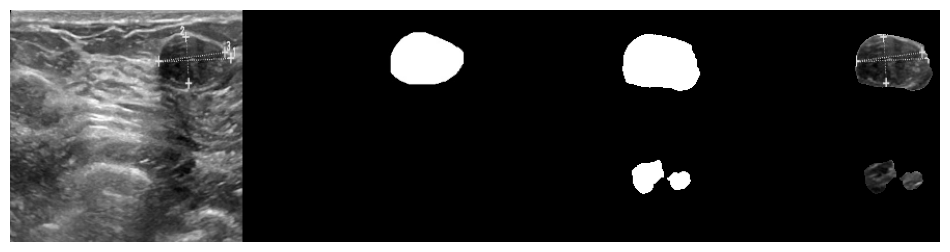

 Epoch: 36 of 100, Iter.: 33 of 33, Train Loss: 0.281714, IoU: 0.788276, Dice: 0.858888
 Epoch: 36 of 100, Iter.: 33 of 33, Valid Loss: 0.483597, IoU: 0.567468, Dice: 0.649650


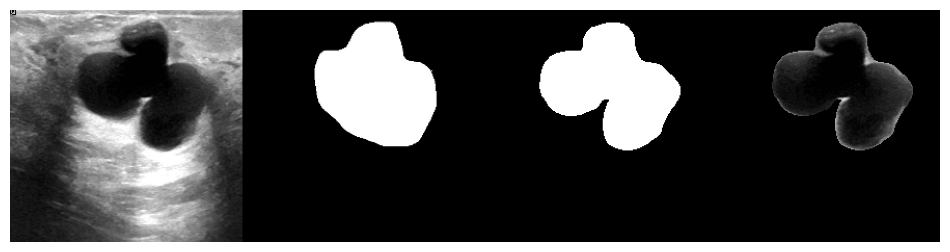

 Epoch: 37 of 100, Iter.: 33 of 33, Train Loss: 0.301614, IoU: 0.763364, Dice: 0.838105
 Epoch: 37 of 100, Iter.: 33 of 33, Valid Loss: 0.453319, IoU: 0.548569, Dice: 0.625173


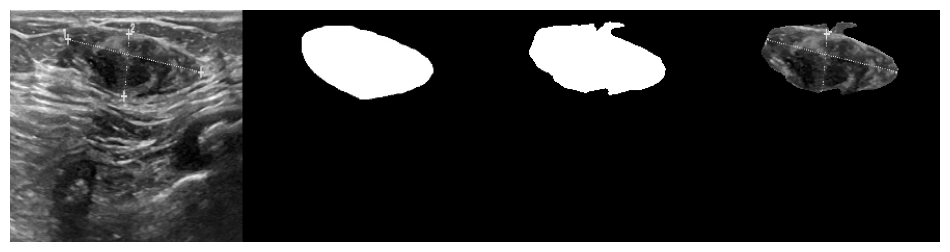

 Epoch: 38 of 100, Iter.: 33 of 33, Train Loss: 0.296706, IoU: 0.761135, Dice: 0.842976
 Epoch: 38 of 100, Iter.: 33 of 33, Valid Loss: 0.401488, IoU: 0.630304, Dice: 0.702105


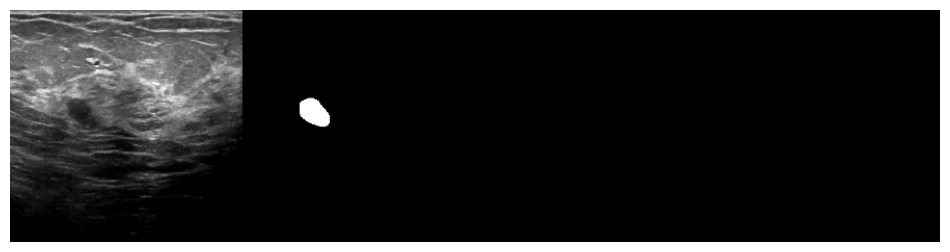

 Epoch: 39 of 100, Iter.: 33 of 33, Train Loss: 0.265948, IoU: 0.790800, Dice: 0.865406
 Epoch: 39 of 100, Iter.: 33 of 33, Valid Loss: 0.487757, IoU: 0.542331, Dice: 0.634600


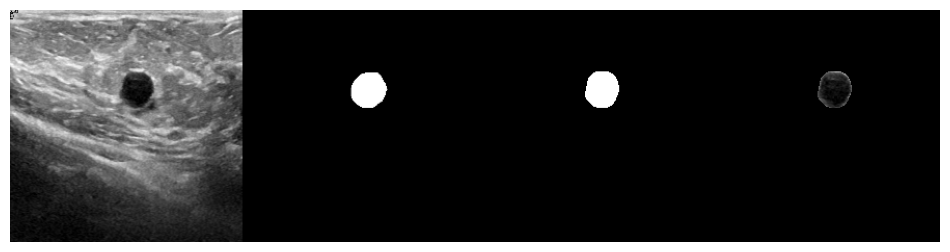

 Epoch: 40 of 100, Iter.: 33 of 33, Train Loss: 0.285373, IoU: 0.760967, Dice: 0.839349
 Epoch: 40 of 100, Iter.: 33 of 33, Valid Loss: 0.445713, IoU: 0.605873, Dice: 0.686673


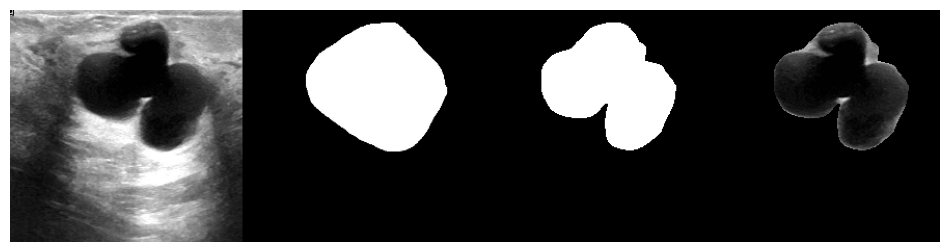

 Epoch: 41 of 100, Iter.: 33 of 33, Train Loss: 0.249788, IoU: 0.778171, Dice: 0.852905
 Epoch: 41 of 100, Iter.: 33 of 33, Valid Loss: 0.431635, IoU: 0.600409, Dice: 0.679521


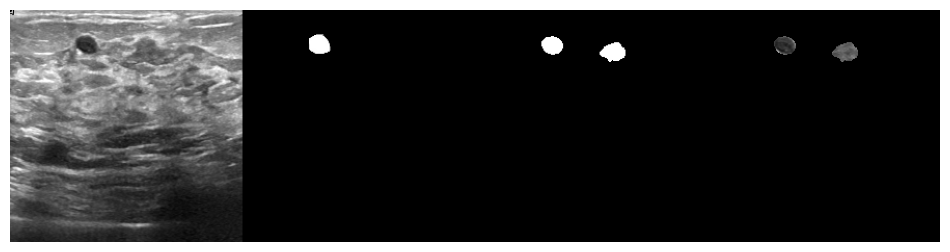

 Epoch: 42 of 100, Iter.: 33 of 33, Train Loss: 0.218095, IoU: 0.821001, Dice: 0.885151
 Epoch: 42 of 100, Iter.: 33 of 33, Valid Loss: 0.451395, IoU: 0.600379, Dice: 0.674568


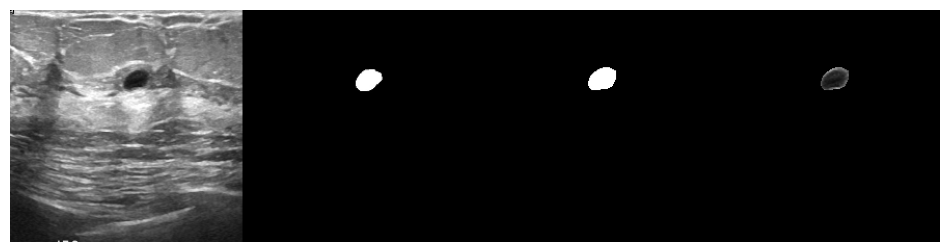

 Epoch: 43 of 100, Iter.: 33 of 33, Train Loss: 0.194127, IoU: 0.840164, Dice: 0.899642
 Epoch: 43 of 100, Iter.: 33 of 33, Valid Loss: 0.377819, IoU: 0.642722, Dice: 0.724281


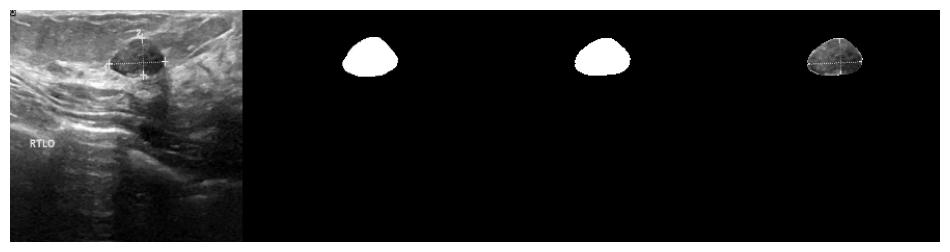

 Epoch: 44 of 100, Iter.: 33 of 33, Train Loss: 0.212474, IoU: 0.835293, Dice: 0.895142
 Epoch: 44 of 100, Iter.: 33 of 33, Valid Loss: 0.391585, IoU: 0.646609, Dice: 0.728196


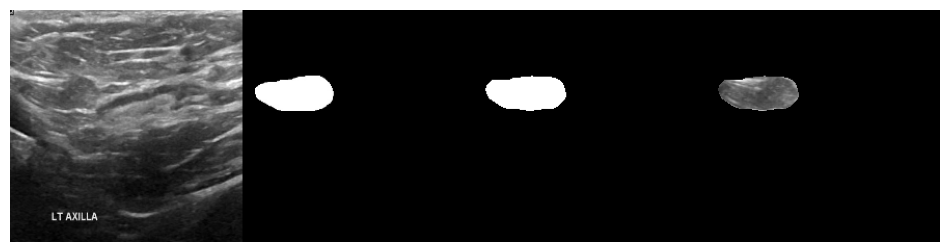

 Epoch: 45 of 100, Iter.: 33 of 33, Train Loss: 0.194562, IoU: 0.838096, Dice: 0.898365
 Epoch: 45 of 100, Iter.: 33 of 33, Valid Loss: 0.403820, IoU: 0.614566, Dice: 0.694627


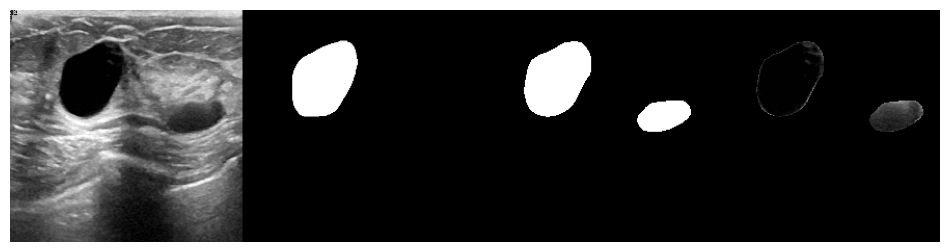

 Epoch: 46 of 100, Iter.: 33 of 33, Train Loss: 0.189893, IoU: 0.841853, Dice: 0.898888
 Epoch: 46 of 100, Iter.: 33 of 33, Valid Loss: 0.366035, IoU: 0.657166, Dice: 0.737677


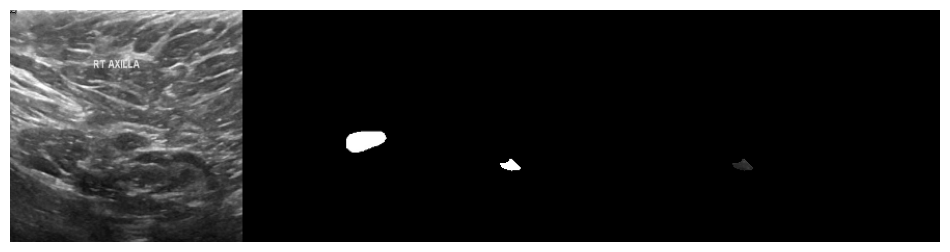

 Epoch: 47 of 100, Iter.: 33 of 33, Train Loss: 0.183415, IoU: 0.846121, Dice: 0.903007
 Epoch: 47 of 100, Iter.: 33 of 33, Valid Loss: 0.407675, IoU: 0.599694, Dice: 0.671601


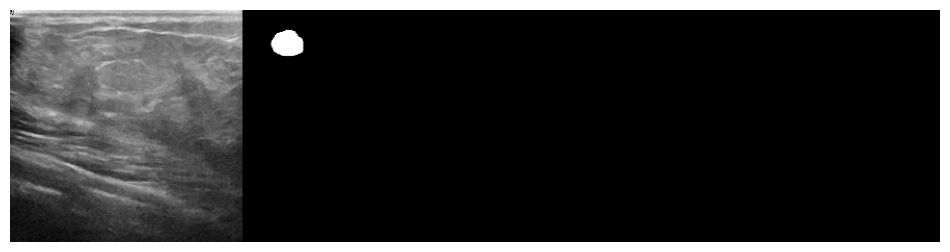

 Epoch: 48 of 100, Iter.: 33 of 33, Train Loss: 0.161581, IoU: 0.855954, Dice: 0.909233
 Epoch: 48 of 100, Iter.: 33 of 33, Valid Loss: 0.368131, IoU: 0.617254, Dice: 0.699404


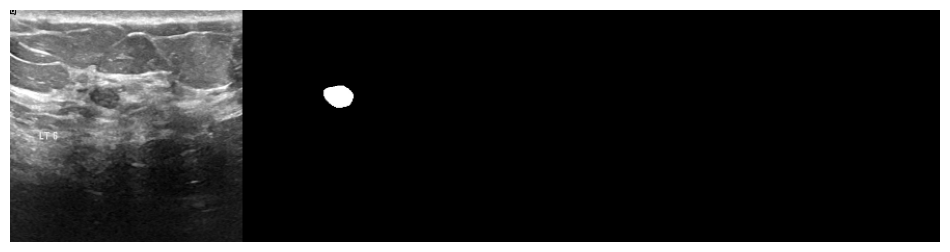

 Epoch: 49 of 100, Iter.: 33 of 33, Train Loss: 0.169254, IoU: 0.852835, Dice: 0.907105
 Epoch: 49 of 100, Iter.: 33 of 33, Valid Loss: 0.367342, IoU: 0.651873, Dice: 0.734332


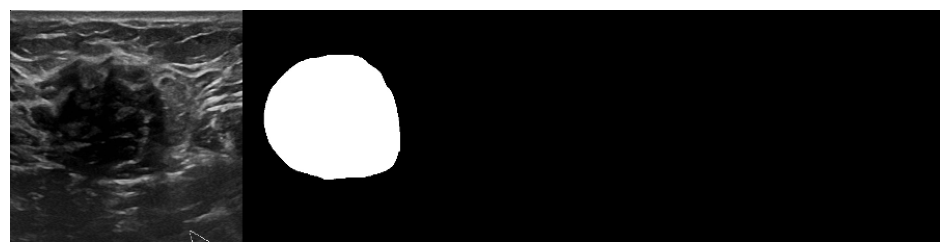

 Epoch: 50 of 100, Iter.: 33 of 33, Train Loss: 0.155322, IoU: 0.850489, Dice: 0.904939
 Epoch: 50 of 100, Iter.: 33 of 33, Valid Loss: 0.375395, IoU: 0.661911, Dice: 0.745584


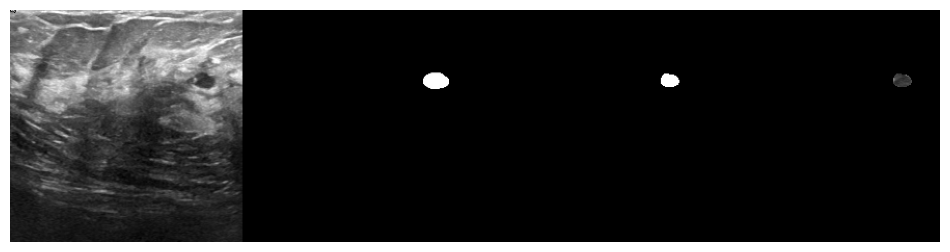

 Epoch: 51 of 100, Iter.: 33 of 33, Train Loss: 0.153062, IoU: 0.857299, Dice: 0.909667
 Epoch: 51 of 100, Iter.: 33 of 33, Valid Loss: 0.392830, IoU: 0.659010, Dice: 0.733539


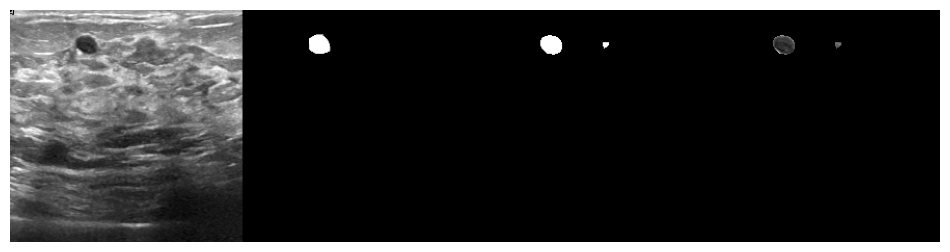

 Epoch: 52 of 100, Iter.: 33 of 33, Train Loss: 0.157956, IoU: 0.857069, Dice: 0.910182
 Epoch: 52 of 100, Iter.: 33 of 33, Valid Loss: 0.421313, IoU: 0.594529, Dice: 0.683867


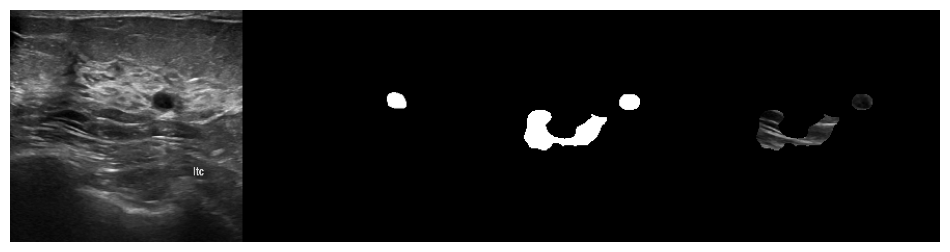

 Epoch: 53 of 100, Iter.: 33 of 33, Train Loss: 0.194792, IoU: 0.812841, Dice: 0.874214
 Epoch: 53 of 100, Iter.: 33 of 33, Valid Loss: 0.441074, IoU: 0.604064, Dice: 0.696957


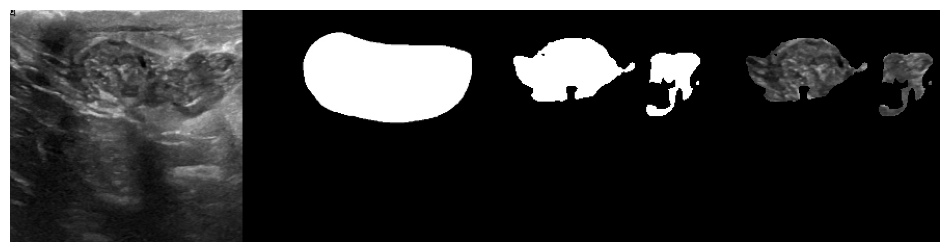

 Epoch: 54 of 100, Iter.: 33 of 33, Train Loss: 0.245141, IoU: 0.753500, Dice: 0.830765
 Epoch: 54 of 100, Iter.: 33 of 33, Valid Loss: 0.446341, IoU: 0.558836, Dice: 0.656069


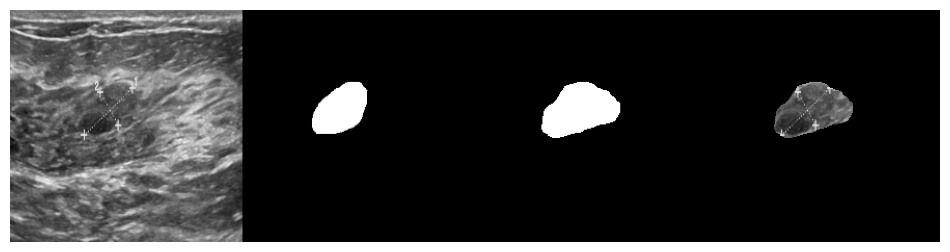

 Epoch: 55 of 100, Iter.: 33 of 33, Train Loss: 0.226444, IoU: 0.777777, Dice: 0.854395
 Epoch: 55 of 100, Iter.: 33 of 33, Valid Loss: 0.466088, IoU: 0.561196, Dice: 0.664197


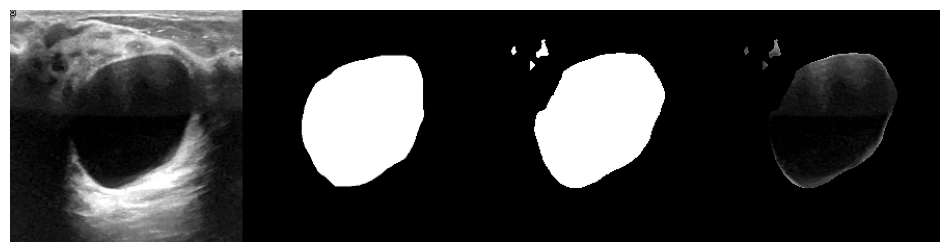

 Epoch: 56 of 100, Iter.: 33 of 33, Train Loss: 0.202939, IoU: 0.804049, Dice: 0.872575
 Epoch: 56 of 100, Iter.: 33 of 33, Valid Loss: 0.391363, IoU: 0.648644, Dice: 0.726359


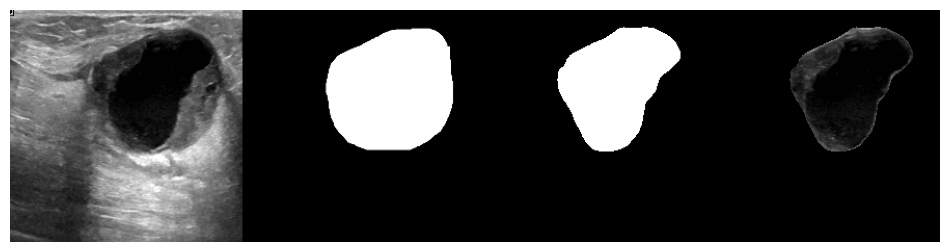

 Epoch: 57 of 100, Iter.: 33 of 33, Train Loss: 0.166621, IoU: 0.827762, Dice: 0.889985
 Epoch: 57 of 100, Iter.: 33 of 33, Valid Loss: 0.397338, IoU: 0.632206, Dice: 0.709904


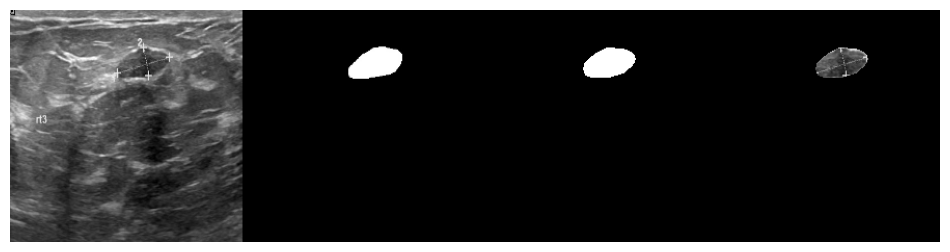

 Epoch: 58 of 100, Iter.: 33 of 33, Train Loss: 0.147460, IoU: 0.844185, Dice: 0.900318
 Epoch: 58 of 100, Iter.: 33 of 33, Valid Loss: 0.348346, IoU: 0.670238, Dice: 0.745776


 Epoch: 59 of 100, Iter.: 33 of 33, Train Loss: 0.132391, IoU: 0.862921, Dice: 0.914707
 Epoch: 59 of 100, Iter.: 33 of 33, Valid Loss: 0.349484, IoU: 0.660352, Dice: 0.734038


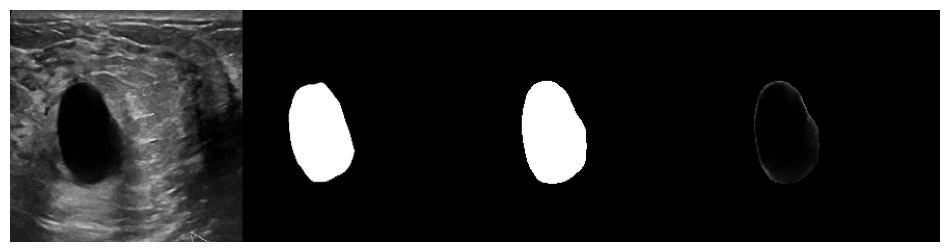

 Epoch: 60 of 100, Iter.: 33 of 33, Train Loss: 0.132177, IoU: 0.863663, Dice: 0.913016
 Epoch: 60 of 100, Iter.: 33 of 33, Valid Loss: 0.367364, IoU: 0.658987, Dice: 0.734932


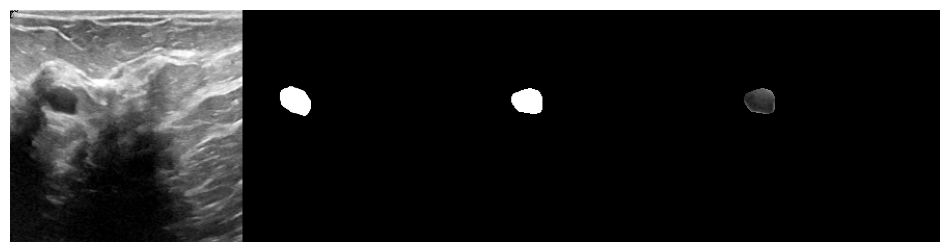

 Epoch: 61 of 100, Iter.: 33 of 33, Train Loss: 0.119484, IoU: 0.878408, Dice: 0.924037
 Epoch: 61 of 100, Iter.: 33 of 33, Valid Loss: 0.366332, IoU: 0.658156, Dice: 0.735781


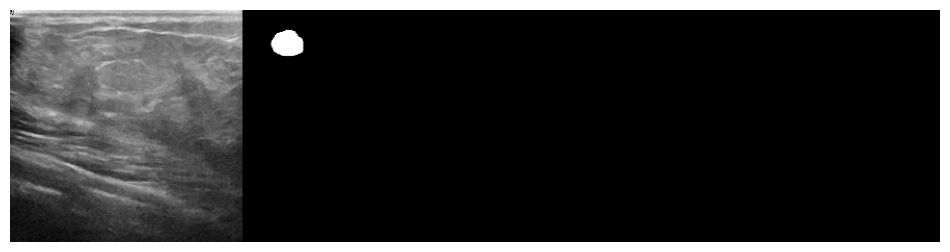

 Epoch: 62 of 100, Iter.: 33 of 33, Train Loss: 0.115792, IoU: 0.875172, Dice: 0.921690
 Epoch: 62 of 100, Iter.: 33 of 33, Valid Loss: 0.375394, IoU: 0.657515, Dice: 0.736163


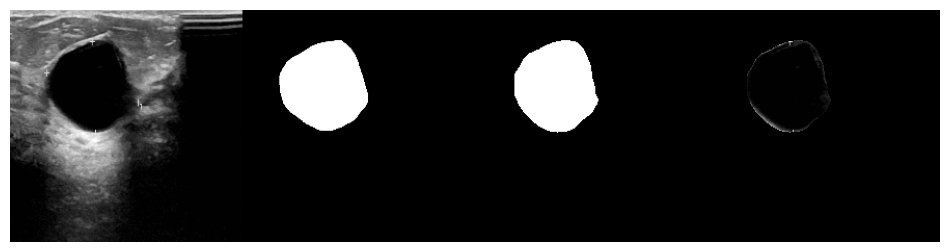

 Epoch: 63 of 100, Iter.: 33 of 33, Train Loss: 0.139419, IoU: 0.860886, Dice: 0.911972
 Epoch: 63 of 100, Iter.: 33 of 33, Valid Loss: 0.422401, IoU: 0.635236, Dice: 0.725269


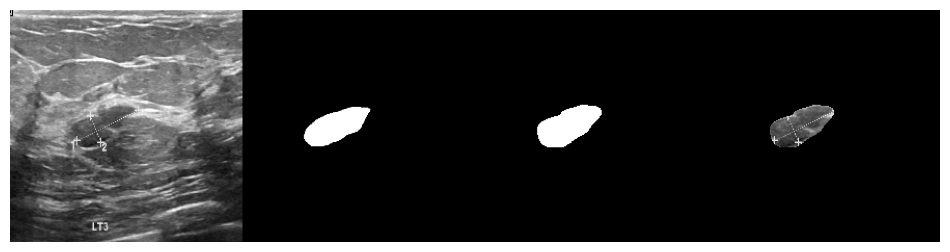

 Epoch: 64 of 100, Iter.: 33 of 33, Train Loss: 0.133735, IoU: 0.858622, Dice: 0.910637
 Epoch: 64 of 100, Iter.: 33 of 33, Valid Loss: 0.423867, IoU: 0.608914, Dice: 0.697474


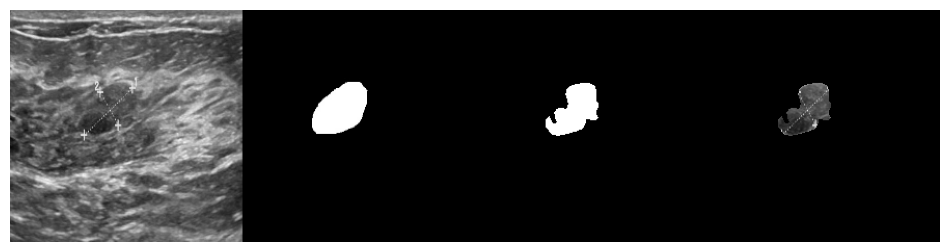

 Epoch: 65 of 100, Iter.: 33 of 33, Train Loss: 0.132019, IoU: 0.855437, Dice: 0.907788
 Epoch: 65 of 100, Iter.: 33 of 33, Valid Loss: 0.393842, IoU: 0.626658, Dice: 0.713867


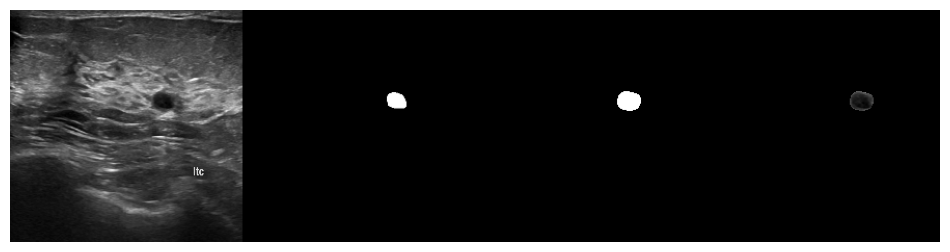

 Epoch: 66 of 100, Iter.: 33 of 33, Train Loss: 0.131085, IoU: 0.851061, Dice: 0.906874
 Epoch: 66 of 100, Iter.: 33 of 33, Valid Loss: 0.344238, IoU: 0.659290, Dice: 0.743348


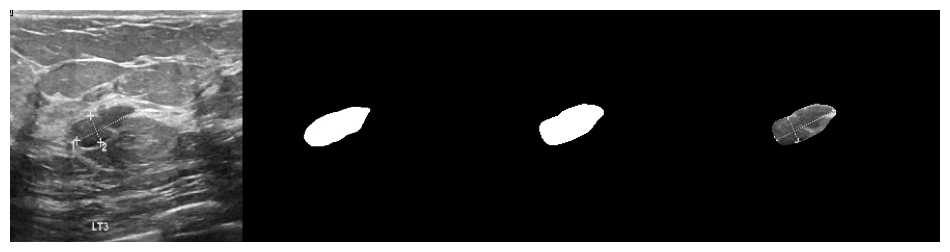

 Epoch: 67 of 100, Iter.: 33 of 33, Train Loss: 0.121857, IoU: 0.866834, Dice: 0.916949
 Epoch: 67 of 100, Iter.: 33 of 33, Valid Loss: 0.362371, IoU: 0.657338, Dice: 0.737134


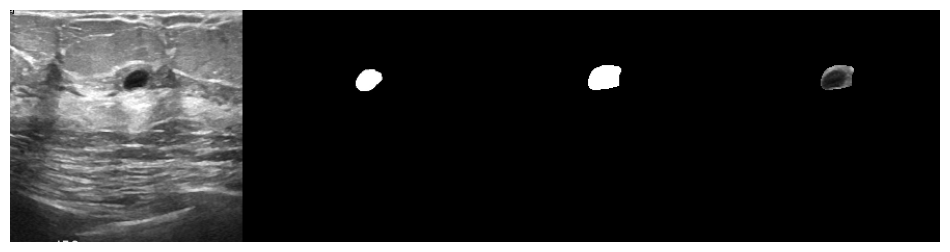

 Epoch: 68 of 100, Iter.: 33 of 33, Train Loss: 0.114247, IoU: 0.872675, Dice: 0.920598
 Epoch: 68 of 100, Iter.: 33 of 33, Valid Loss: 0.334652, IoU: 0.663710, Dice: 0.742962


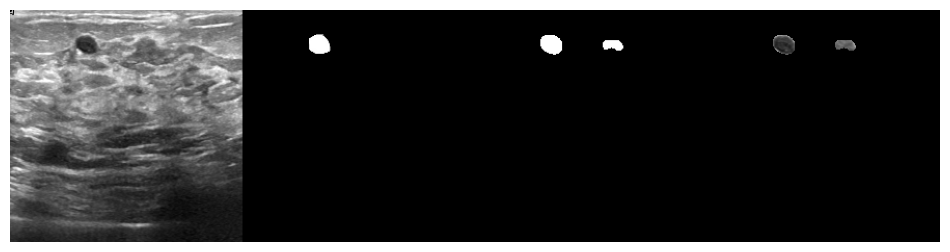

 Epoch: 69 of 100, Iter.: 33 of 33, Train Loss: 0.102396, IoU: 0.881845, Dice: 0.927164
 Epoch: 69 of 100, Iter.: 33 of 33, Valid Loss: 0.366663, IoU: 0.641964, Dice: 0.729378


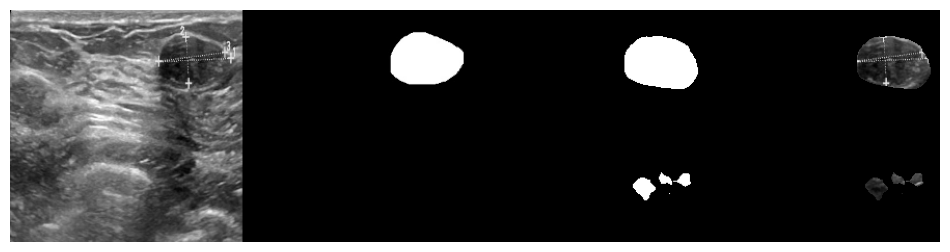

 Epoch: 70 of 100, Iter.: 33 of 33, Train Loss: 0.093972, IoU: 0.893146, Dice: 0.933388
 Epoch: 70 of 100, Iter.: 33 of 33, Valid Loss: 0.366121, IoU: 0.662767, Dice: 0.744909


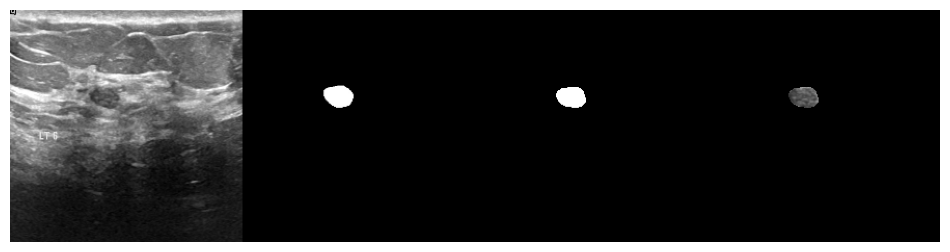

 Epoch: 71 of 100, Iter.: 33 of 33, Train Loss: 0.099443, IoU: 0.890313, Dice: 0.932099
 Epoch: 71 of 100, Iter.: 33 of 33, Valid Loss: 0.363409, IoU: 0.646530, Dice: 0.722773


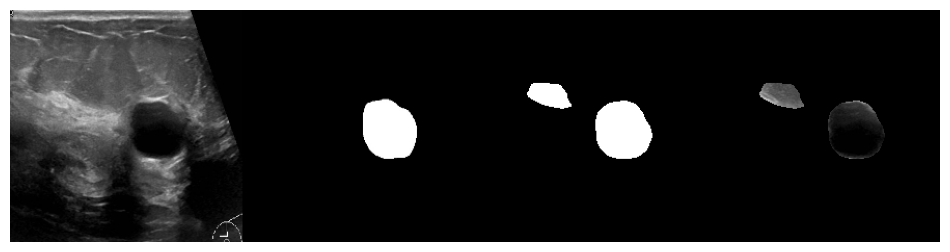

 Epoch: 72 of 100, Iter.: 33 of 33, Train Loss: 0.090987, IoU: 0.895798, Dice: 0.935365
 Epoch: 72 of 100, Iter.: 33 of 33, Valid Loss: 0.354898, IoU: 0.661324, Dice: 0.740157


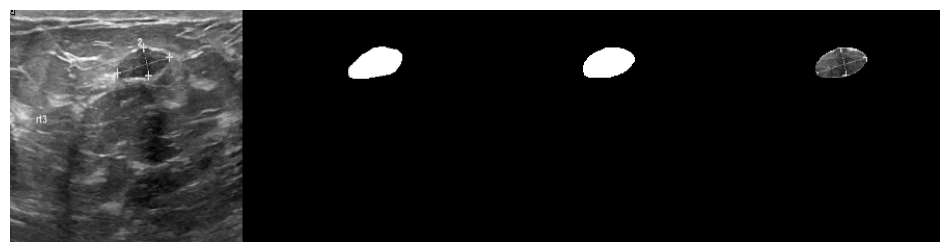

 Epoch: 73 of 100, Iter.: 33 of 33, Train Loss: 0.083965, IoU: 0.897246, Dice: 0.935102
 Epoch: 73 of 100, Iter.: 33 of 33, Valid Loss: 0.361068, IoU: 0.658842, Dice: 0.742045


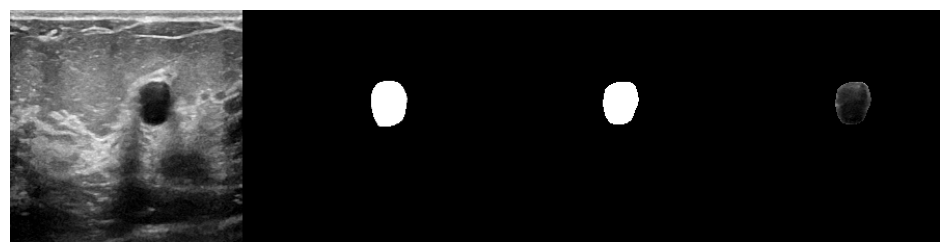

 Epoch: 74 of 100, Iter.: 33 of 33, Train Loss: 0.096188, IoU: 0.893962, Dice: 0.934227
 Epoch: 74 of 100, Iter.: 33 of 33, Valid Loss: 0.370447, IoU: 0.654481, Dice: 0.740415


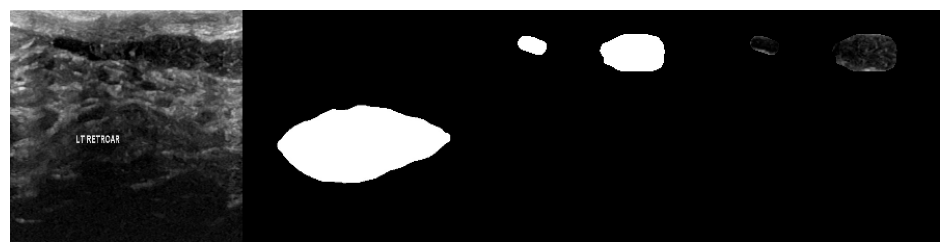

 Epoch: 75 of 100, Iter.: 33 of 33, Train Loss: 0.084404, IoU: 0.899515, Dice: 0.938452
 Epoch: 75 of 100, Iter.: 33 of 33, Valid Loss: 0.343437, IoU: 0.667902, Dice: 0.748879


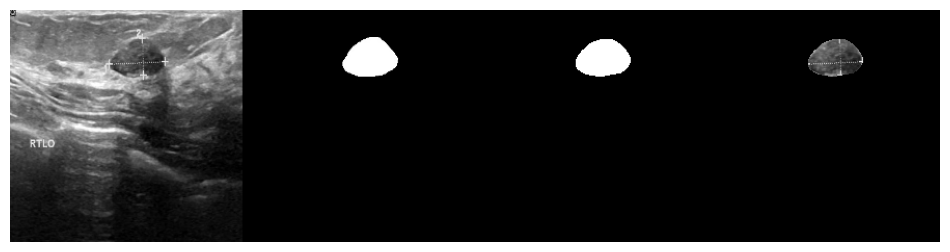

 Epoch: 76 of 100, Iter.: 33 of 33, Train Loss: 0.083832, IoU: 0.900628, Dice: 0.938379
 Epoch: 76 of 100, Iter.: 33 of 33, Valid Loss: 0.405924, IoU: 0.640624, Dice: 0.726781


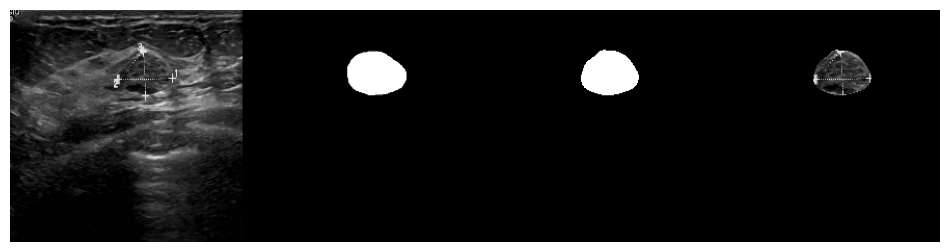

 Epoch: 77 of 100, Iter.: 33 of 33, Train Loss: 0.082103, IoU: 0.900356, Dice: 0.940962
 Epoch: 77 of 100, Iter.: 33 of 33, Valid Loss: 0.375847, IoU: 0.630488, Dice: 0.724074


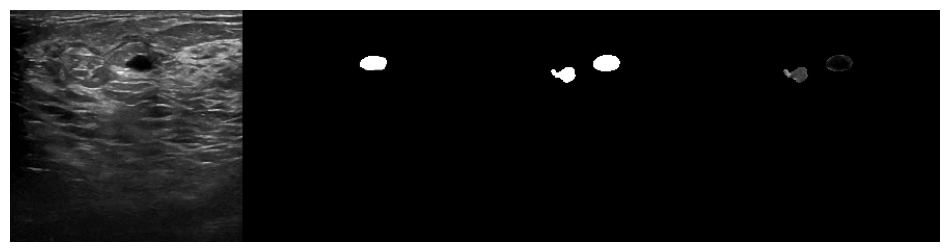

 Epoch: 78 of 100, Iter.: 33 of 33, Train Loss: 0.096160, IoU: 0.886100, Dice: 0.931486
 Epoch: 78 of 100, Iter.: 33 of 33, Valid Loss: 0.422863, IoU: 0.584153, Dice: 0.672785


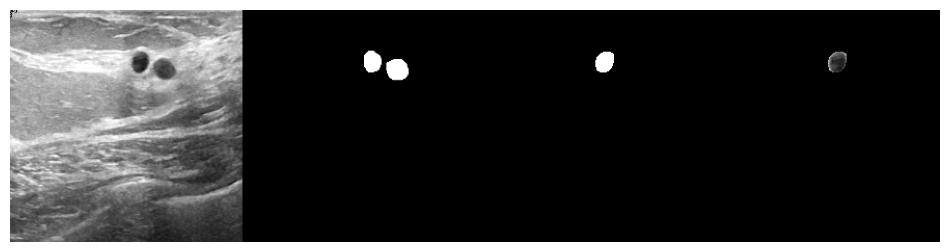

 Epoch: 79 of 100, Iter.: 33 of 33, Train Loss: 0.144775, IoU: 0.817514, Dice: 0.883914
 Epoch: 79 of 100, Iter.: 33 of 33, Valid Loss: 0.514048, IoU: 0.506505, Dice: 0.599354


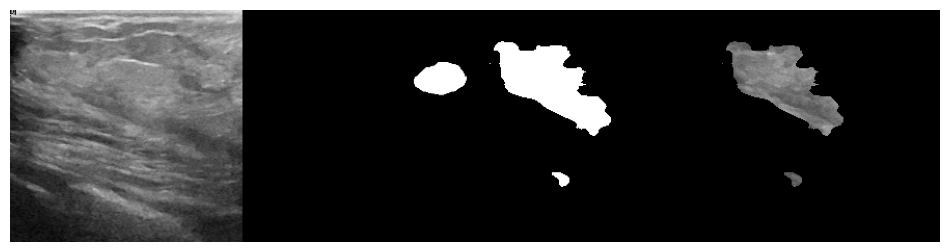

 Epoch: 80 of 100, Iter.: 33 of 33, Train Loss: 0.131038, IoU: 0.850328, Dice: 0.905810
 Epoch: 80 of 100, Iter.: 33 of 33, Valid Loss: 0.402698, IoU: 0.609089, Dice: 0.691076


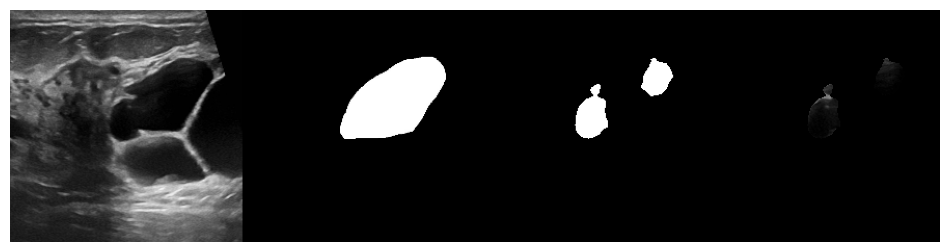

 Epoch: 81 of 100, Iter.: 33 of 33, Train Loss: 0.129006, IoU: 0.839920, Dice: 0.898690
 Epoch: 81 of 100, Iter.: 33 of 33, Valid Loss: 0.443038, IoU: 0.615181, Dice: 0.694913


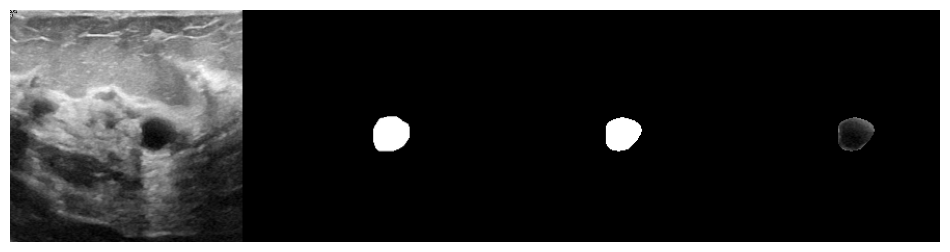

 Epoch: 82 of 100, Iter.: 33 of 33, Train Loss: 0.132159, IoU: 0.842429, Dice: 0.902654
 Epoch: 82 of 100, Iter.: 33 of 33, Valid Loss: 0.455193, IoU: 0.580541, Dice: 0.682985


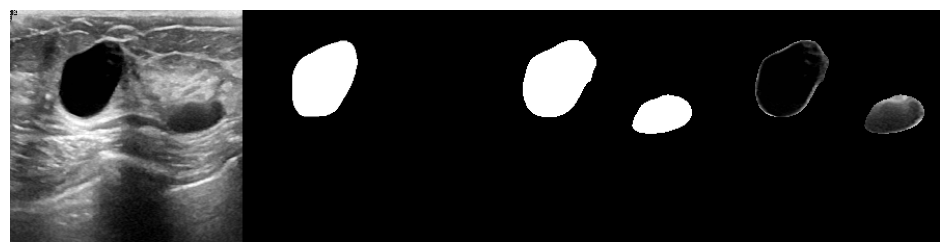

 Epoch: 83 of 100, Iter.: 33 of 33, Train Loss: 0.129602, IoU: 0.849724, Dice: 0.905077
 Epoch: 83 of 100, Iter.: 33 of 33, Valid Loss: 0.374323, IoU: 0.590405, Dice: 0.680631


 Epoch: 84 of 100, Iter.: 33 of 33, Train Loss: 0.094282, IoU: 0.880361, Dice: 0.927907
 Epoch: 84 of 100, Iter.: 33 of 33, Valid Loss: 0.365854, IoU: 0.651625, Dice: 0.737118


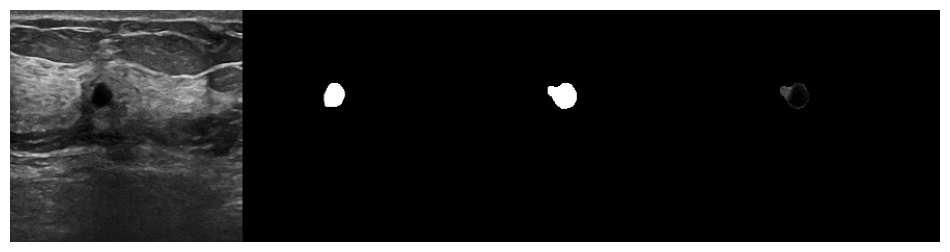

 Epoch: 85 of 100, Iter.: 33 of 33, Train Loss: 0.081768, IoU: 0.888574, Dice: 0.934700
 Epoch: 85 of 100, Iter.: 33 of 33, Valid Loss: 0.353898, IoU: 0.681165, Dice: 0.762997


 Epoch: 86 of 100, Iter.: 33 of 33, Train Loss: 0.077994, IoU: 0.898507, Dice: 0.941834
 Epoch: 86 of 100, Iter.: 33 of 33, Valid Loss: 0.324257, IoU: 0.680689, Dice: 0.764252


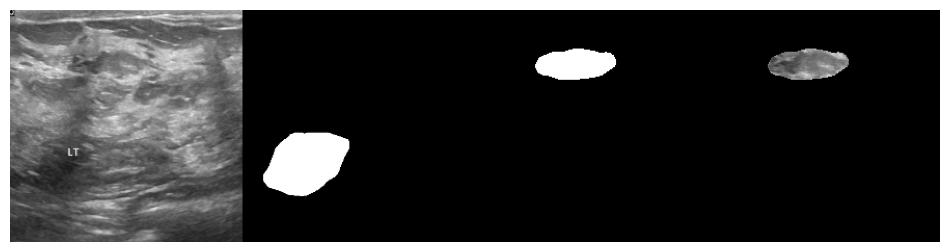

 Epoch: 87 of 100, Iter.: 33 of 33, Train Loss: 0.083767, IoU: 0.895994, Dice: 0.940545
 Epoch: 87 of 100, Iter.: 33 of 33, Valid Loss: 0.348488, IoU: 0.680778, Dice: 0.761427


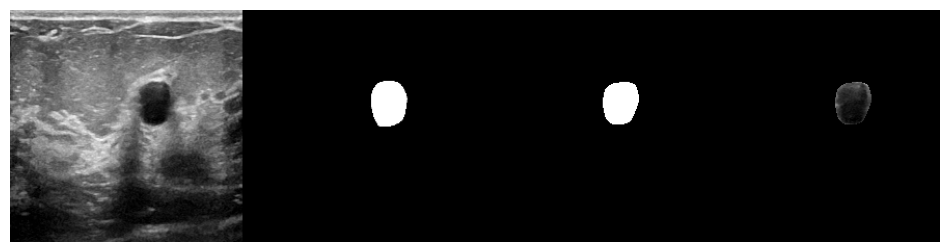

 Epoch: 88 of 100, Iter.: 33 of 33, Train Loss: 0.077826, IoU: 0.903160, Dice: 0.944373
 Epoch: 88 of 100, Iter.: 33 of 33, Valid Loss: 0.345732, IoU: 0.689846, Dice: 0.770732


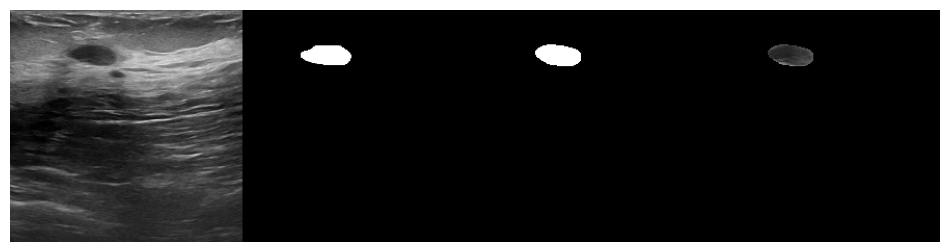

 Epoch: 89 of 100, Iter.: 33 of 33, Train Loss: 0.067623, IoU: 0.908164, Dice: 0.946148
 Epoch: 89 of 100, Iter.: 33 of 33, Valid Loss: 0.348949, IoU: 0.667814, Dice: 0.745765


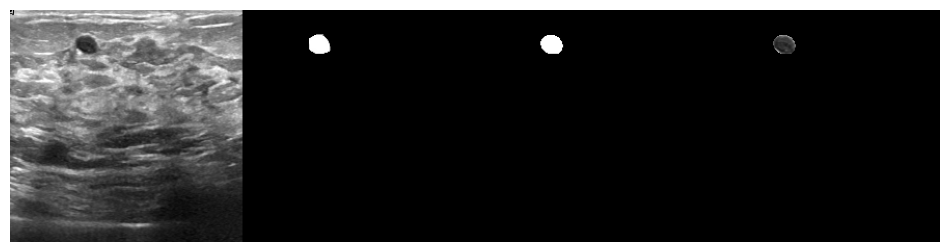

 Epoch: 90 of 100, Iter.: 33 of 33, Train Loss: 0.060299, IoU: 0.914114, Dice: 0.950589
 Epoch: 90 of 100, Iter.: 33 of 33, Valid Loss: 0.331435, IoU: 0.689906, Dice: 0.763971


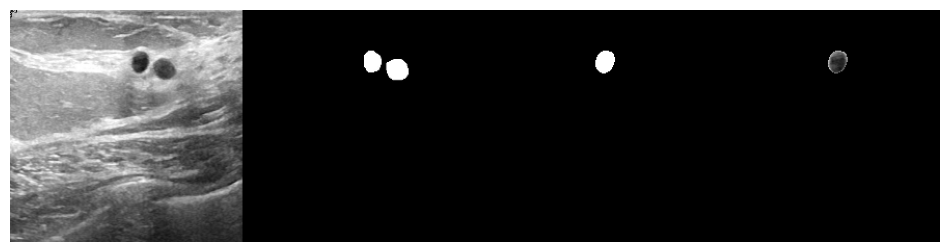

 Epoch: 91 of 100, Iter.: 33 of 33, Train Loss: 0.054931, IoU: 0.923502, Dice: 0.957823
 Epoch: 91 of 100, Iter.: 33 of 33, Valid Loss: 0.350716, IoU: 0.676415, Dice: 0.759179


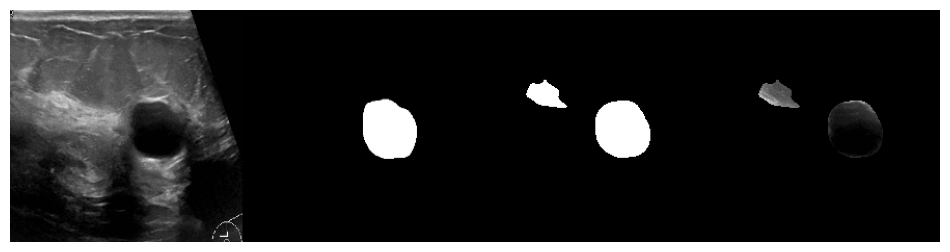

 Epoch: 92 of 100, Iter.: 33 of 33, Train Loss: 0.057650, IoU: 0.923848, Dice: 0.957870
 Epoch: 92 of 100, Iter.: 33 of 33, Valid Loss: 0.355131, IoU: 0.689192, Dice: 0.765090


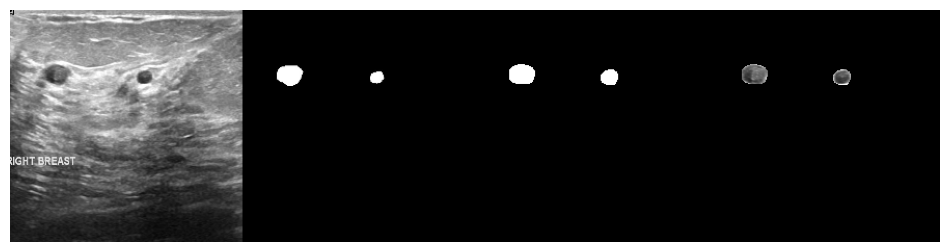

 Epoch: 93 of 100, Iter.: 33 of 33, Train Loss: 0.053910, IoU: 0.924727, Dice: 0.958389
 Epoch: 93 of 100, Iter.: 33 of 33, Valid Loss: 0.347801, IoU: 0.695384, Dice: 0.773600


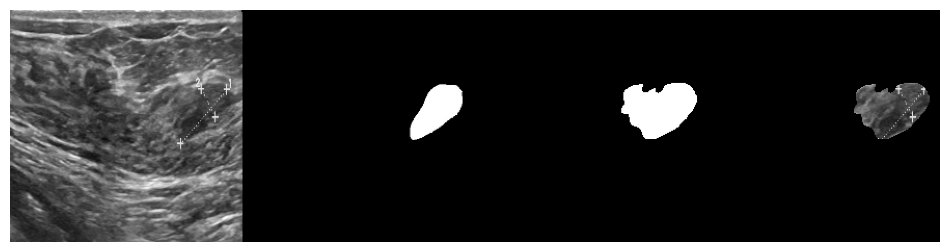

 Epoch: 94 of 100, Iter.: 33 of 33, Train Loss: 0.054180, IoU: 0.924881, Dice: 0.958749
 Epoch: 94 of 100, Iter.: 33 of 33, Valid Loss: 0.352705, IoU: 0.682782, Dice: 0.762449


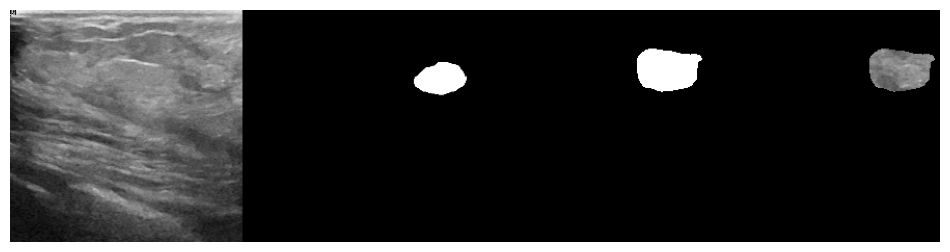

 Epoch: 95 of 100, Iter.: 33 of 33, Train Loss: 0.050176, IoU: 0.930234, Dice: 0.962359
 Epoch: 95 of 100, Iter.: 33 of 33, Valid Loss: 0.343410, IoU: 0.690157, Dice: 0.770754


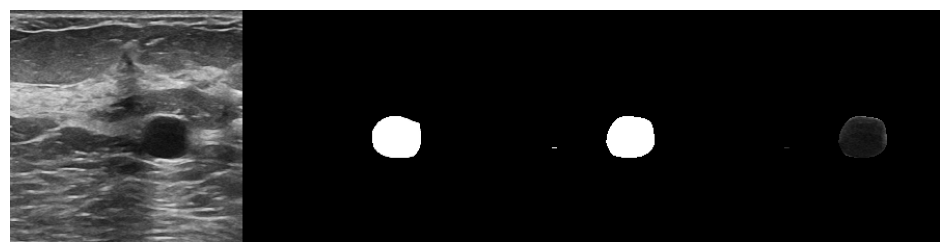

 Epoch: 96 of 100, Iter.: 33 of 33, Train Loss: 0.049005, IoU: 0.929800, Dice: 0.962234
 Epoch: 96 of 100, Iter.: 33 of 33, Valid Loss: 0.371435, IoU: 0.666732, Dice: 0.744563


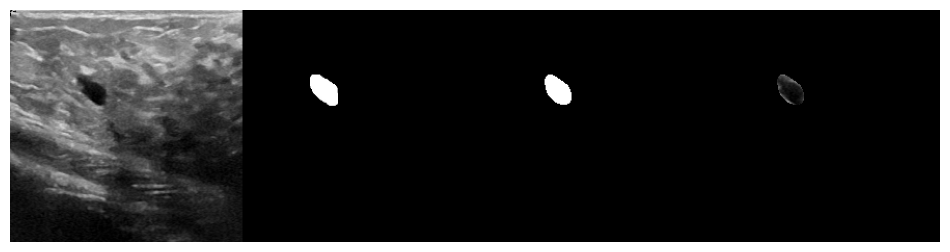

 Epoch: 97 of 100, Iter.: 33 of 33, Train Loss: 0.050628, IoU: 0.929095, Dice: 0.961651
 Epoch: 97 of 100, Iter.: 33 of 33, Valid Loss: 0.353290, IoU: 0.689259, Dice: 0.767520


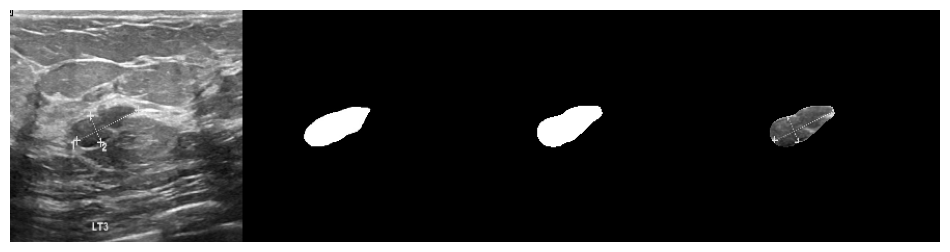

 Epoch: 98 of 100, Iter.: 33 of 33, Train Loss: 0.045787, IoU: 0.934106, Dice: 0.964752
 Epoch: 98 of 100, Iter.: 33 of 33, Valid Loss: 0.343349, IoU: 0.685974, Dice: 0.766014


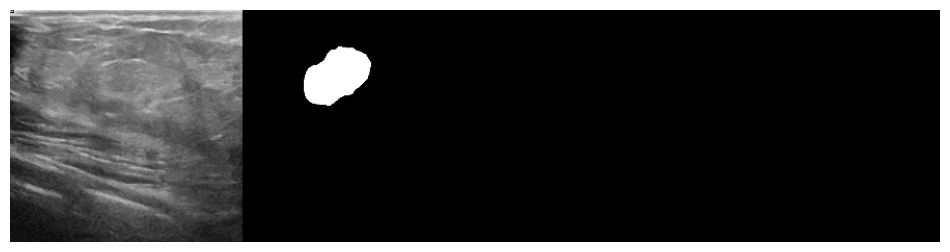

 Epoch: 99 of 100, Iter.: 33 of 33, Train Loss: 0.043572, IoU: 0.936080, Dice: 0.965541
 Epoch: 99 of 100, Iter.: 33 of 33, Valid Loss: 0.351462, IoU: 0.668921, Dice: 0.752168


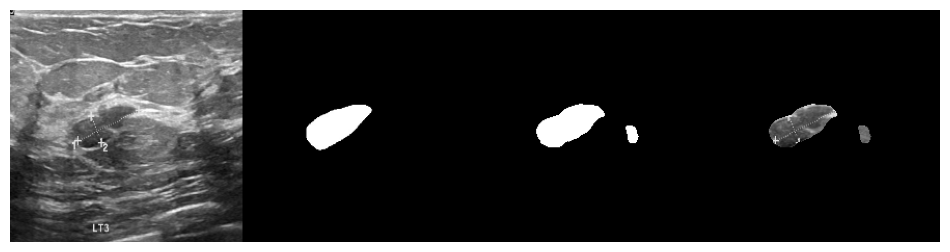

 Epoch: 100 of 100, Iter.: 33 of 33, Train Loss: 0.044243, IoU: 0.934640, Dice: 0.964880
 Epoch: 100 of 100, Iter.: 33 of 33, Valid Loss: 0.369504, IoU: 0.670404, Dice: 0.750488


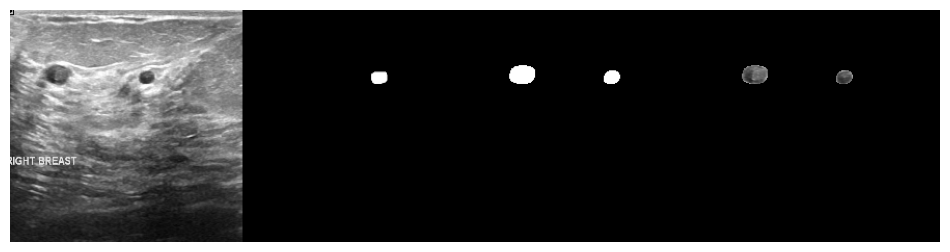

CPU times: user 7min 54s, sys: 6min 21s, total: 14min 15s
Wall time: 7min 29s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:93, Best_IOU:0.6954, Best_DiceScore:0.7736


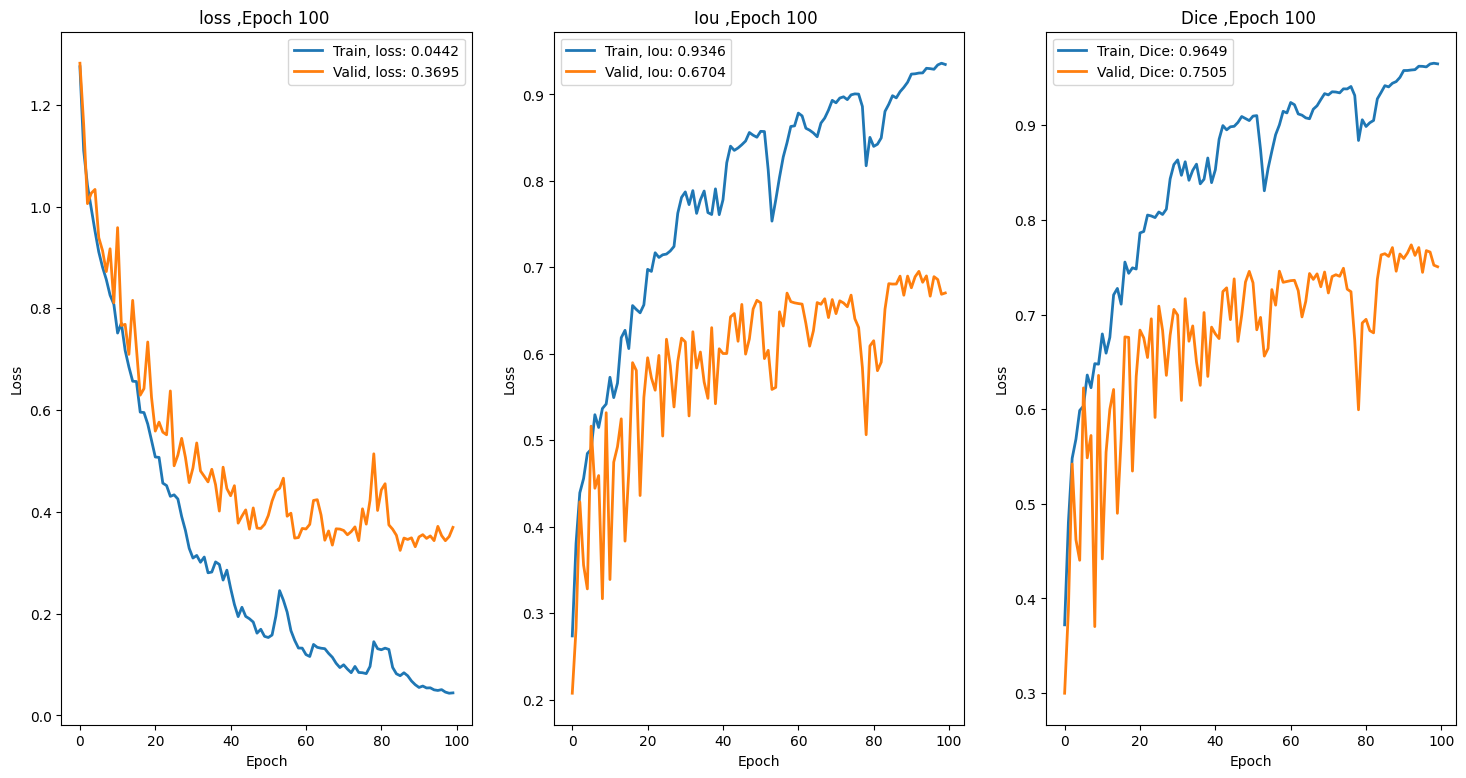

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()